## Automated Systematic Review

## Introduction


## Problem statement and project goals
The aim of this project is to develop and evaluate models to reduce the time and therefore the costs of conducting systematic reviews. There are various tools that automate the process of systematic reviews. While these tools mainly apply classical models, our project is aimed to explore deep learning models. 

Another goal of this project is applying active learning methods and compare them with the classical random approach. Active learning is a type of iterative supervised learning method that select the most informative data points to get labeled by an expert during multiple iterations. In scenarios where not enough labled data is available and manually labeling data is expensive, Active learning is expected to show better performance than random approach. 

We would like to validate our model on several databases with different sizes and various rates of included papers, rather than relying on a single database.

## Approach
Our approach is based on the following:
- Apply title and abstract screening.
- Build models with a pre-trained word embeddings from Wikipedia
- Start training models with a defined number of initially included papers.
- Run models on High Performance Computers (HPC)


## Dataset
our model is evaluated on the following datasets:
- Systematic Review on Post-Traumatic Stress Disorder (van de Schoot et al., 2018)
- 7 systematic drug class reviews (Cohen et al., 2006)
- Systematic Review on depression(Cuijpers et al., 2018)

## Modeling
In this project we developed models using deep learning algorithms and then compared them to classical algorithms based on the following evaluation criteria.    

### Evaluation criteria
- minimize the number of relevant papers that is missed, i.e. False Negatives =< 5 
- minimize the total number of papers to read including seen and selected papers

### Deep Learning algorithms
In this project we explored two types of deep learning algorithms which are commonly applied to various NLP tasks.

1. Long Short-Term Memory (LSTM) forward/backward
2. Convolutional Neural Network(CNN)

These models were built with a pre-trained word embeddings from Wikipedia and tested on various hyperparameters such as various numbers of epochs, batches, dropouts, and different optimization algorithms. We evaluated the models based on the above mentioned criteria. Among the algorithms LSTM backward represented the better results.

### Classical algorithms
We compared our Deep Learning model with Rayyan, a web and mobile app for systematic reviews. Rayyan uses Support Vector Machine (SVM) as a classifier.

## Paper selection methods
There are different ways of selecting papers to present to researchers for labeling. The following are two approaches that we applied.

### Passive Learning
Papers are randomly selected from datasets.

### Active Learning
Papers are selected for labeling based on a query strategy. A query strategy basically chooses the most informative papers to get the best out of the model when there are not many labeled data available.

## Results


In [1]:
import os
import re
import glob
import warnings
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


from sklearn import metrics
from scipy import stats

In [181]:
#dataset_name ="ptsd"
#dataset_name ="ProtonPumpInhibitors"
#dataset_name = "BetaBlockers"
#dataset_name ="CalciumChannelBlockers"
#dataset_name = "Opiods"
dataset_name = "ACEInhibitors"
#dataset_name = "AtypicalAntipsychotics"
#dataset_name = "Statins"
# dataset_name = "depression"
# year = '2015'

In [118]:
def get_threshholds(pred):
    """Defines a range of threshholds for a given list of predictions

    params
    ------
    name: pred
        A vector including prediction probabilities
        
    Returns:
    -------
        A list of threshholds
    """
    desc = stats.describe(pred)
    (min_prob, max_prob) = desc.minmax
    
    step = (max_prob - min_prob) / 25
    threshholds = [i for i in np.arange(max_prob, min_prob - step, -step)]
    threshholds += [min_prob]
    return threshholds

def get_scores_threshhold(pred, labels, threshhold):
    """Calculates metrics based on a given threshhold

    params
    ------
    name: pred
        A vector including prediction probabilities

    name: labels
            A vector including labels

    name: threshhold
        A float number

    Returns:
    -------
        a tuple of tn, fp, fn, tp
    """
    y_classes = ([0 if x < float(threshhold) else 1 for x in pred])
    (tn, fp, fn, tp) = sklearn.metrics.confusion_matrix(labels, y_classes).ravel()
    return (tn, fp, fn, tp)

def get_scores(pred, labels, allowed_FN):
    """Find the best matrics by tweaking threshhold

    params
    ------
    name: pred
        A vector including prediction probabilities

    name: labels
            A vector including labels

    name: allowed_FN
        An integer shows the number of relative papers that can be misclassified

    Returns:
    -------
        a tuple of best tn, fp, fn, tp
    """
    threshholds = get_threshholds(pred)
    best_tn, best_fp, best_fn, best_tp = get_scores_threshhold(
                                            pred, labels, threshholds[0]
                                         )
    ## calculate scores for each threshhold
    for i, threshhold in enumerate(threshholds):
        tn, fp, fn, tp = get_scores_threshhold(
            pred, labels, threshhold)
        if (fn <= allowed_FN) and (best_fn > allowed_FN) and (threshhold >0):
            best_tn = tn
            best_fp = fp
            best_fn = fn
            best_tp = tp
        else:  #when fn meets the requirement, we select a smaller threshhold just when it decreases fp.
            if (fn <= allowed_FN) and (best_fp > fp) and (threshhold > 0):
                best_tn = tn
                best_fp = fp
                best_fn = fn
                best_tp = tp
    return (float(best_tn), float(best_fp), float(best_fn), float(best_tp))


### Passive learning results 


#### Read output files

In [182]:
#Warning: This part takes a while to run. You need to run it once.
#calculate metrics and save the results to a file
def calculate_metrics_passive(dataset_name,allowed_FN):
    """Aggregate row outputs and save in one .csv file 

    params
    ------
    name: dataset_name
        A string including dataset name

    name: allowed_FN
        An integer shows the number of relative papers that can be misclassified

    """
    simul_no=0
    column_names = ['simulation','tn','fp','fn','tp','training_size','init_included_papers','allowed_FN']
    dir_name = dataset_name+year if dataset_name=='depression' else dataset_name
    scores = list()
    for fp in glob.glob(os.path.join('..','output','passive',dir_name, 'dataset_{}_sr_lstm*.csv'.format(dataset_name))):
            simul_no +=1 
            with open(fp) as csv_file:
                # load the result into memory 
                df = pd.read_csv(fp)
                file_name =os.path.basename(fp)
                init_included_papers = re.search(r'(_included_papers)(\d{2})', file_name).group(2)

            df_ = df.loc[df['pred'] != -1]
            training_size = len(df.loc[df['pred'] == -1])
            (tn,fp,fn,tp)=get_scores(df_.iloc[:,2], df_.iloc[:,1], allowed_FN)  
            scores.append([simul_no, tn,fp,fn,tp,training_size,init_included_papers,allowed_FN])
    
    scores_df = pd.DataFrame.from_records(scores, columns=column_names)
    scores_df.to_csv(os.path.join('..', 'output','passive',dir_name, 'systematic_review_results_allowed_FN_{}.csv'.format(allowed_FN)))  
        
calculate_metrics_passive(dataset_name,5)

There are two types of systematic review, one-time systematic reveiw and iterative systematic review.
## One-time systematic review

### Visualization

Here we represent the reduction in the number and the ratio of papers to read, based on the training size and the number of initially included papers. We test it for three datasets including PTSD, BetaBlockers and ACEInhibitors.


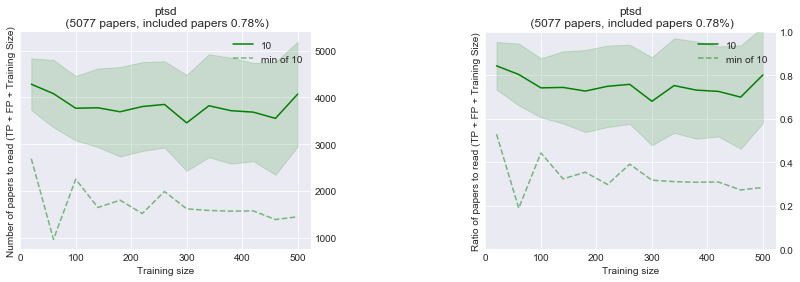

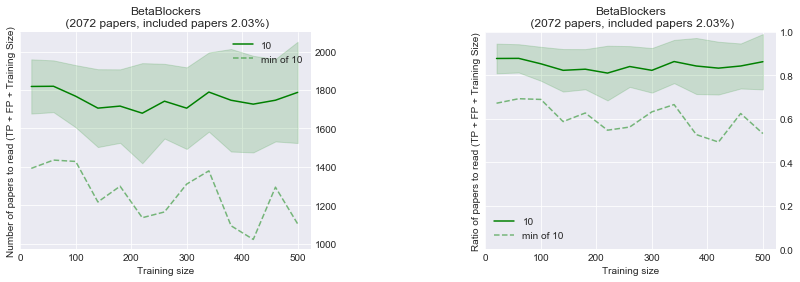

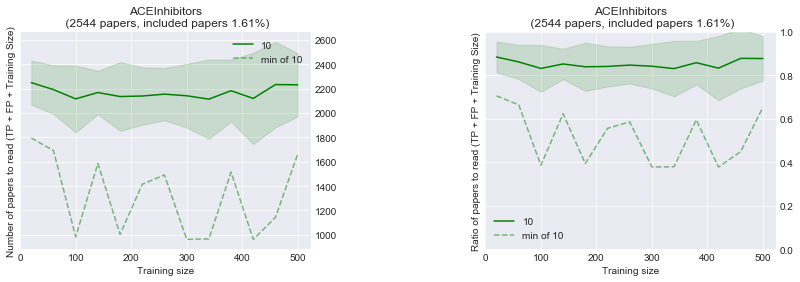

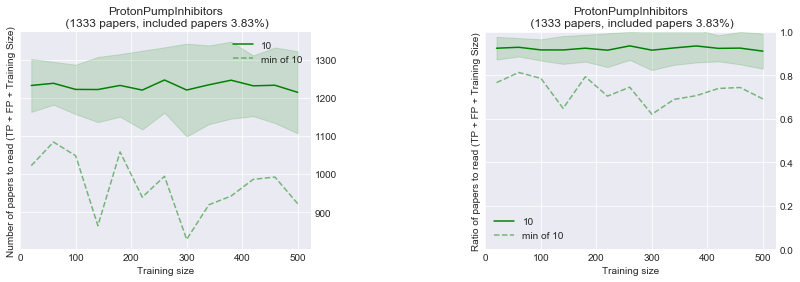

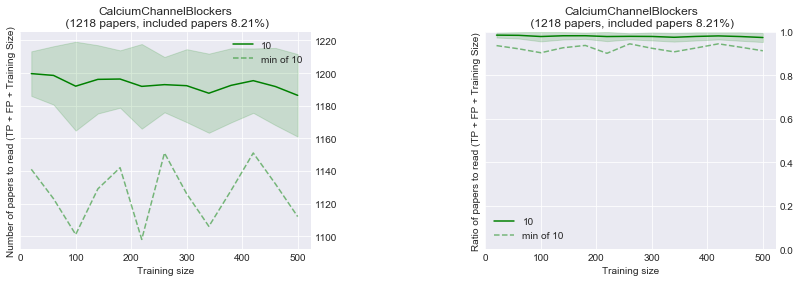

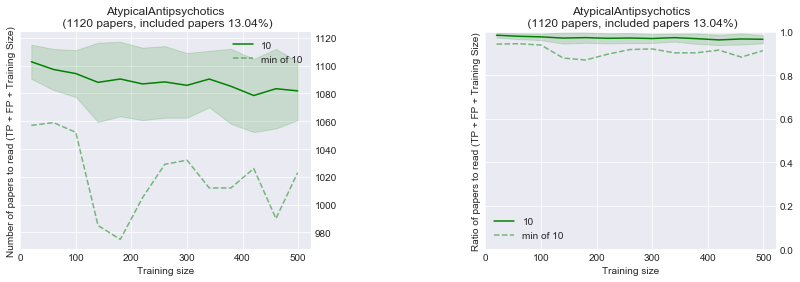

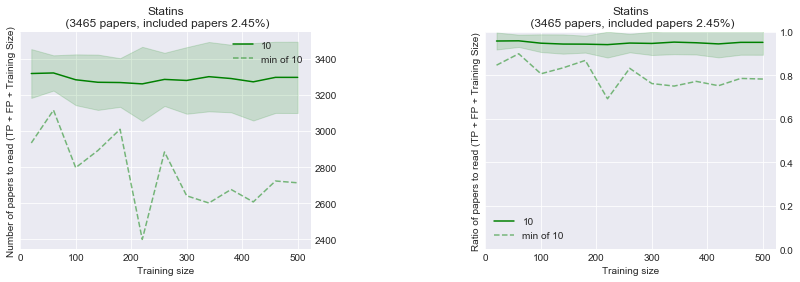

In [172]:
def make_plot_papers_to_read_passive(axs, dataset_name, allowed_FN, init_included_papers, col_dict):#, dropout=0.4:
    """Prepare the plots 

    params
    ------
    name: An array of Axes objects that are created by subplot

    name: dataset_name
        A string including dataset name

    name: allowed_FN
        An integer shows the number of relative papers that can be misclassified

    name: init_included_papers
            The number of papers are initially included in the trained dataset

    name: col_dict
            A dictionary of colors assigned to the number of initially included papers

    """

    df_summary = pd.read_csv(os.path.join('..', 'output','passive',dataset_name, 'systematic_review_results_allowed_FN_{}.csv'.format(allowed_FN))) 

    #calculate the number of papers to read
    df_summary['to_read_plus_train_number'] = df_summary['fp']+df_summary['tp']+df_summary['training_size']
    df_summary['to_read_plus_train_rate'] = df_summary['to_read_plus_train_number']/(df_summary['fp']+
                                                df_summary['fn']+df_summary['tp']+df_summary['tn']+ df_summary['training_size'])

    measure_names = ['to_read_plus_train_number', 'to_read_plus_train_rate']
    for i in range(0, len(measure_names)):

        r = measure_names[i]
        m = df_summary.groupby(['training_size','init_included_papers']).mean()[r].unstack()
        st = df_summary.groupby(['training_size','init_included_papers']).std()[r].unstack()
        min_ = df_summary.groupby(['training_size','init_included_papers']).min()[r].unstack()

        

        ax = axs[i]
        for s in init_included_papers:
            ax.plot(m.index, m[s], col_dict[s], label=s)
            ax.fill_between(m.index, m[s] - st[s], m[s] + st[s], color=col_dict[s], alpha=0.15)
            ax.plot(m.index, min_[s], "{}--".format(col_dict[s]), alpha=0.5, label="min of {}".format(s))


        ax.set_xlabel("Training size") 
        if r == 'to_read_plus_train_rate':
            ax.set_ylabel("Ratio of papers to read (TP + FP + Training Size)") 
            ax.set_ylim([0,1])
            ax.set_title(dataset_name+'\n ('+dataset_info[dataset_name]+')')
        elif r == 'to_read_plus_train_number':
            ax.set_ylabel("Number of papers to read (TP + FP + Training Size)") 
            ax.set_title(dataset_name+'\n ('+dataset_info[dataset_name]+')')
        else:
            raise Exception

        ax.set_xlim(left=0)
        ax.yaxis.tick_right()

        ax.legend() #loc='best'
        

def show_papers_to_read_passive(dataset_name, allowed_FN=1): #, dropout=0.4
    """Prepare the plots 

    params
    ------
    name: An array of Axes objects that are created by subplot

    name: dataset_name
        A string including dataset name

    name: allowed_FN
        An integer shows the number of relative papers that can be misclassified

    name: init_included_papers
            The number of papers are initially included in the trained dataset

    name: col_dict
            A dictionary of colors assigned to the number of initially included papers

    """

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    fig.subplots_adjust(left=0.2, wspace=0.6)
    make_plot_papers_to_read_passive(axs, dataset_name, allowed_FN,init_included_papers, col_dict)

    plt.show()              
        
    if not os.path.isdir(os.path.join('..', 'output', 'passive','figures', dataset_name)):
        os.mkdir(os.path.join('..', 'output', 'passive','figures', dataset_name))
    fig.savefig(os.path.join('..','output','passive', "figures", dataset_name, "perf_plot_{}.png".format(dataset_name)), dpi=300)
        
        
dataset_info={'BetaBlockers':'2072 papers, included papers 2.03%', 'ptsd':'5077 papers, included papers 0.78%',
              'ACEInhibitors':'2544 papers, included papers 1.61%', 'AtypicalAntipsychotics':'1120 papers, included papers 13.04%',
              'CalciumChannelBlockers':'1218 papers, included papers 8.21%', 'Opiods':'1915 papers, included papers 0.78%',
              'ProtonPumpInhibitors':'1333 papers, included papers 3.83%', 'Statins':'3465 papers, included papers 2.45%'
              
              }

dataset_name='ptsd'
init_included_papers=[10]
col_dict = {10:'g'} #, 20:'b'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='BetaBlockers'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='ACEInhibitors'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='ProtonPumpInhibitors'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='CalciumChannelBlockers'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='AtypicalAntipsychotics'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        
dataset_name='Statins'
show_papers_to_read_passive(dataset_name, allowed_FN=1)        

###  Comparison among datasets
Here we make a comparison among two datasets: PTSD and ACEInhibitors

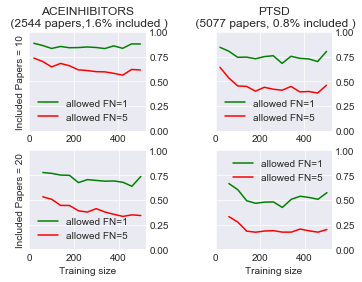

In [194]:
def make_plot_comparison_passive(axs, datasets, allowed_FN, init_included_papers, col_dict):#, dropout=0.4:
    """Prepare the plots that compare the given datasets

    params
    ------
    name: An array of Axes objects that are created by subplot

    name: dataset_name
        A string including dataset name

    name: allowed_FN
        An integer shows the number of relative papers that can be misclassified

    name: init_included_papers
            The number of papers are initially included in the trained dataset

    name: col_dict
            A dictionary of colors assigned to the number of initially included papers

    """

    df_results=pd.DataFrame()
    for ds in datasets:
        for fn in allowed_FN:
            df_ = pd.read_csv(os.path.join('..', 'output','passive',datasets[ds], 'systematic_review_results_allowed_FN_{}.csv'.format(fn))) 
            df_['dataset'] =  datasets[ds]
            df_results = df_results.append(df_)
       
    df_results['to_read_plus_train_number'] = df_results['fp']+df_results['tp']+df_results['training_size']
    df_results['to_read_plus_train_rate'] = df_results['to_read_plus_train_number']/(df_results['fp']+
                                                df_results['fn']+df_results['tp']+df_results['tn']+ df_results['training_size'])

    val = 'to_read_plus_train_rate'
    
    for ds in datasets:
        for inc in init_included_papers:
            ax = axs[inc, ds]
            cond = (df_results['init_included_papers'] == init_included_papers[inc])&(df_results['dataset']==datasets[ds])
            df_summary = df_results.loc[cond,]
            
            m = df_summary.groupby(['training_size','allowed_FN']).mean()[val].unstack()
            
            for s in allowed_FN: 
                 ax.plot(m.index, m[s], col_dict[s], label='allowed FN='+str(s))

            if (ds==0) & (inc==0):
                ax.set_ylabel("Included Papers = 10")

            if (ds==0) & (inc==1):
                ax.set_ylabel("Included Papers = 20")
    
            if inc==0:
                ax.set_title(datasets[ds].upper()+'\n ('+dataset_info[ds]+')')
            
            if inc==1:
                ax.set_xlabel("Training size")
                
            ax.set_ylim([0,1])
            ax.set_xlim(left=0)
            ax.yaxis.tick_right()

            ax.legend(loc='best')

dataset_info={0:'2544 papers,1.6% included ', 1:'5077 papers, 0.8% included '}
datasets ={0:'ACEInhibitors', 1:'ptsd'}
init_included_papers={0:10, 1:20}
allowed_FN =[1,5]
col_dict = {1:'g', 5:'r'}
            
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot_comparison_passive(axs, datasets, allowed_FN, init_included_papers, col_dict)

# just align the last column of axes:
fig.align_ylabels(axs[:, 1])
plt.show()            
if not os.path.isdir(os.path.join('..', 'output', 'passive','figures', 'ptsd')):
    os.mkdir(os.path.join('..', 'output', 'passive','figures', 'ptsd'))
fig.savefig(os.path.join('..','output','passive', "figures", 'ptsd', "perf_plot-{}_{}.png".format('ACE','PTSD')), dpi=300)



## Iterative Systematic Review
One of our datasets is a special case where the systematic review is carried out every year on the same topic, i.e. adult depression. In this case, we assign all the papers, included and excluded papers, from previous years to training set and test our model on the papers from the current year.

### Calculate train size and the ratio of included papers

In [93]:
df_data = pd.read_csv(os.path.join('..', 'data','datasets','depression_review', 'adults_depression.csv'), encoding= "latin-1") 
df_data['date']=list(map(int,df_data['date']))
ex = df_data.loc[(df_data['date']==2015)&(df_data['label']==0),:].shape[0]
inn = df_data.loc[(df_data['date']==2015)&(df_data['label']==1),:].shape[0]
ratio15 = inn/(inn + ex)
print('excluded papers =2015',ex)
print('included papers =2015',inn)
print('included ratio =2015',ratio15)
train_size15 = df_data.loc[(df_data['date']<2015),:].shape[0]
print('train size',train_size15)


ex = df_data.loc[(df_data['date']==2016)&(df_data['label']==0),:].shape[0]
inn = df_data.loc[(df_data['date']==2016)&(df_data['label']==1),:].shape[0]
ratio16 = inn/(inn + ex)
print('excluded papers =2016',ex)
print('included papers =2016',inn)
print('included ratio =2016',ratio16)
train_size16 = df_data.loc[(df_data['date']<2016),:].shape[0]
print('train size',train_size16)


ex = df_data.loc[(df_data['date']==2017)&(df_data['label']==0),:].shape[0]
inn = df_data.loc[(df_data['date']==2017)&(df_data['label']==1),:].shape[0]
ratio17 = inn/(inn + ex)
print('excluded papers =2017',ex)
print('included papers =2017',inn)
print('included ratio =2017',ratio17)
train_size17 = df_data.loc[(df_data['date']<2017),:].shape[0]
print('train size',train_size17)



excluded papers =2015 818
included papers =2015 63
included ratio =2015 0.07150964812712826
train size 9472
excluded papers =2016 822
included papers =2016 50
included ratio =2016 0.05733944954128441
train size 10353
excluded papers =2017 1083
included papers =2017 67
included ratio =2017 0.058260869565217394
train size 11225


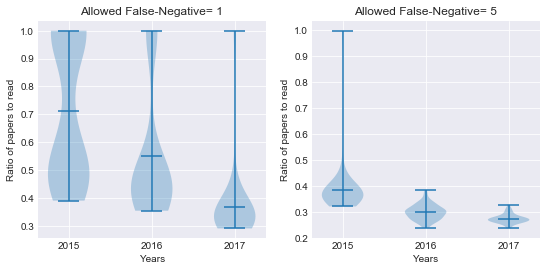

In [173]:
dataset_info =['depression']
dataset_name = "depression"
if dataset_name in  dataset_info:
    selected_col_names=['allowed_FN','to_read_plus_train_number','to_read_plus_train_rate']
    years =[2015,2016,2017]

    df_1={}
    df_5={}

    for y in years:
        df_results = pd.read_csv(os.path.join('..', 'output','passive',dataset_name+str(y), 'systematic_review_results.csv')) 
        mean_1=df_results.loc[(df_results['allowed_FN']==1),'to_read_plus_train_rate'].mean()
        mean_5=df_results.loc[(df_results['allowed_FN']==5),'to_read_plus_train_rate'].mean()


        df_1[y] =df_results.loc[(df_results['allowed_FN']==1),'to_read_plus_train_rate']
        df_5[y] =df_results.loc[(df_results['allowed_FN']==5),'to_read_plus_train_rate']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

    all_data_1 =[df_1[2015],df_1[2016],df_1[2017]]
    all_data_5 =[df_5[2015],df_5[2016],df_5[2017]]

    # plot violin plot
    axes[0].violinplot(all_data_1,
                       showmeans=True,
                       showmedians=False)
    axes[0].set_title('Allowed False-Negative= 1')

    axes[1].violinplot(all_data_5,
                       showmeans=True,
                       showmedians=False)
    axes[1].set_title('Allowed False-Negative= 5')


    # adding horizontal grid lines
    for ax in axes:
        ax.yaxis.grid(True)
        ax.set_xticks([y + 1 for y in range(len(all_data_1))])
        ax.set_xlabel('Years')
        ax.set_ylabel('Ratio of papers to read')

    # add x-tick labels
    plt.setp(axes, xticks=[y + 1 for y in range(len(all_data_1))],
             xticklabels=['2015', '2016', '2017'])
    plt.show()

    if not os.path.isdir(os.path.join('..', 'output', 'passive','figures', 'depression')):
        os.mkdir(os.path.join('..', 'output', 'passive','figures', 'depression'))
    fig.savefig(os.path.join('..','output','passive', "figures", 'depression', "depression_plot.png"), dpi=300)

### Active Learning


In [144]:
def get_score_iterations(df, simul_no, q, allowed_FN=1):
    """Find the best matrics by tweaking threshhold

    params
    ------
    name: df
        A dataframe including prediction probabilities for all simulations

    name: simul_no
        The number of simulations

    name: q
        Name of a query strategy

    Returns:
    -------
        a tuple of simul_no, iteration no, tn, fp, fn, tp, q, train_size
    """

    col_no = len(df.columns)
    scores = list()
    col_names = df.columns.values.tolist()
    for i in np.arange(2,col_no):
        df_ = df.loc[df[col_names[i]] != -1]
        train_size = len(df.loc[df[col_names[i]] == -1])
        (tn,fp,fn,tp)=get_scores(df_.iloc[:,i], df_.iloc[:,1], allowed_FN)  
        scores.append([simul_no, i-2, tn,fp,fn,tp,q,train_size])
    return scores

#Warning: This part takes a while to run. You need to run it once.
#calculate metrics and save the results to a file
def calculate_metrics_active(dataset_name,allowed_FN):
    column_names = ['simulation','iteration','tn','fp','fn','tp','q','train_size']

    simul_no =0

    for q in ['random','lc','lcbmc']: #
        scores= list()
        for fp in glob.glob(os.path.join('..','output','active_learning',dataset_name,q, 
                                         'dataset_{}_systematic_review_active*_q_{}.csv'.format(dataset_name,q))):
            simul_no +=1 
            with open(fp) as csv_file:
                # load the result into memory 
                df = pd.read_csv(fp)
            score_simulation = get_score_iterations(df, simul_no, q ,allowed_FN) 
            scores +=score_simulation

        scores_df = pd.DataFrame.from_records(scores, columns=column_names)

        #calculate the number of initially included papers
        #Here we are interested in the number of included papers, so we devide it by 2
        scores_df['init_included_papers']=scores_df.loc[scores_df['iteration']==0,'train_size']/2

        #copy the number of initially included papers for all iterations of a simulation
        for index, row in scores_df.loc[scores_df['iteration']==0,['simulation','init_included_papers']].iterrows():
            scores_df.loc[scores_df['simulation']==row['simulation'],'init_included_papers']=row['init_included_papers']

        #store the result
        scores_df.to_csv(os.path.join('..', 'output','active_learning',dataset_name,q, 'systematic_review_results.csv'))
        
calculate_metrics_active(dataset_name,1)        

In [98]:
def collect_results(dataset_name, query_strategy):
    ##collect the results of all query strategy in one dataFrame
    df_results = pd.DataFrame()
    for q in query_strategy:
        df_result=pd.read_csv(os.path.join('..','output','active_learning',dataset_name,q, 
                                         'systematic_review_results.csv'))
        df_results = df_results.append(df_result)


    #calculate the number of papers to read
    df_results['to_read_plus_train_number'] = df_results['fp']+df_results['tp']+df_results['train_size']
    df_results['to_read_plus_train_rate'] = df_results['to_read_plus_train_number']/(df_results['fp']+
                                                df_results['fn']+df_results['tp']+df_results['tn']+ df_results['train_size'])
    return df_results

## Visualization

The following shows the number of papers to read, based on the training size of the papers. The number of initially included papers in all active learning approaches is set to 10.

In [198]:
def make_qs_plot(axs, dataset_name, query_strategy, df_results):
    
    col_names = ['simulation','train_size','to_read_plus_train_rate']
    for q in range(0,len(query_strategy)):
        df_mean=pd.DataFrame()
        df_mean['idx']=np.arange(20,500,40)
        
        df= df_results.loc[((df_results['q']==query_strategy[q])), col_names]

        #reshape the dataframe, using 'pivot' for visualization
        df_res = df.pivot(index='train_size',columns='simulation',values='to_read_plus_train_rate')
        df_res['mean']=df_res.mean(axis=1)

        #keep mean of 10 included papers in another dataframe
        df_mean =pd.merge(df_mean,df_res['mean'].to_frame(), how='left', left_on='idx',right_index=True) 

        ax = axs[q]
        for column in df_res:
            ax.plot(df_res.index, df_res[column], marker='', color='gray', linewidth=1, alpha=0.4)

        df_mean.columns=['idx','mean10']           
        ax.plot(df_mean['idx'], df_mean['mean10'], marker='', color= 'r', linewidth=4, alpha=0.7)
        

        ax.set_xlim([0,500])
        ax.set_xlabel('Training size')
        if q==0:
            ax.set_ylabel('Rate of papers to read')
        ax.set_title(dataset_name +' - '+query_strategy[q])

    
    
def show_qs_plot(dataset_name, query_strategy, df_results):
    plt.style.use('seaborn-darkgrid')
    my_dpi=96
    plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    fig.subplots_adjust(left=0.2, wspace=0.6)
    make_qs_plot(axs, dataset_name, query_strategy, df_results)

    plt.show()              

    if not os.path.isdir(os.path.join('..', 'output', 'active_learning','figures', dataset_name)):
        os.mkdir(os.path.join('..', 'output', 'active_learning','figures', dataset_name))
    fig.savefig(os.path.join('..','output','active_learning', "figures", dataset_name, "plot_qs_{}_{}.png".format('Number_of_papers_to_read',dataset_name)), dpi=300)
    
   

<Figure size 480x480 with 0 Axes>

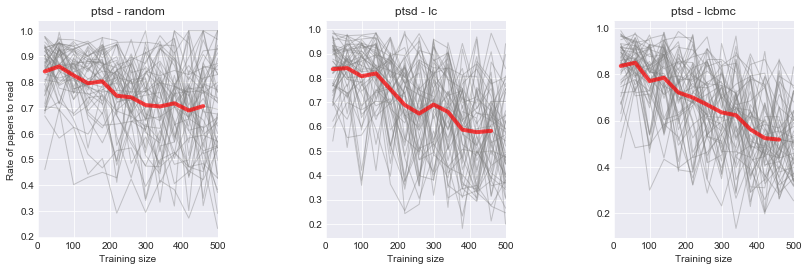

<Figure size 480x480 with 0 Axes>

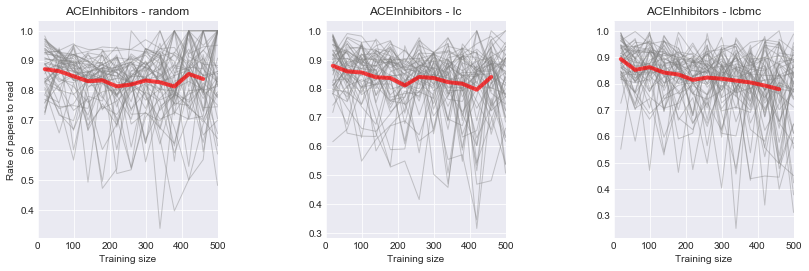

<Figure size 480x480 with 0 Axes>

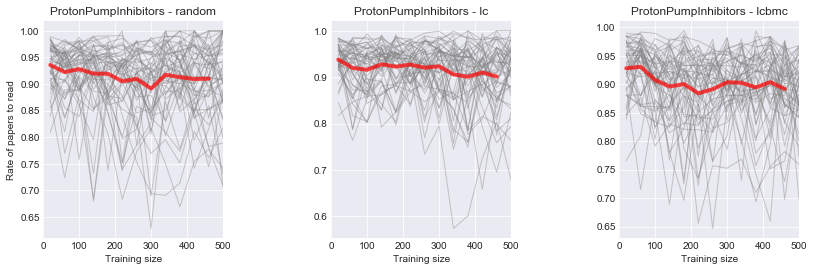

<Figure size 480x480 with 0 Axes>

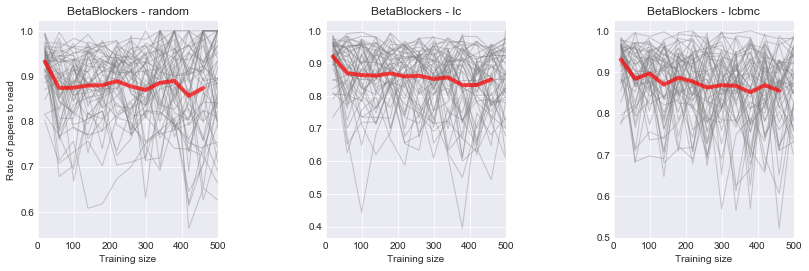

<Figure size 480x480 with 0 Axes>

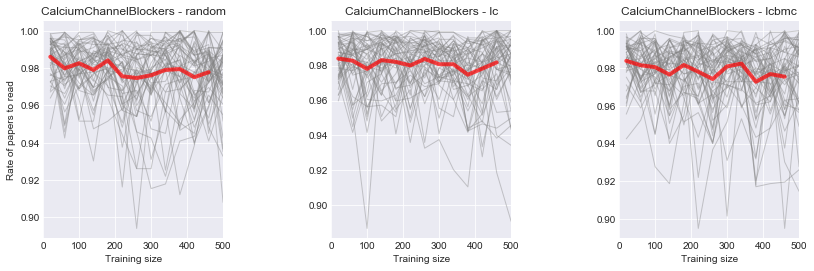

<Figure size 480x480 with 0 Axes>

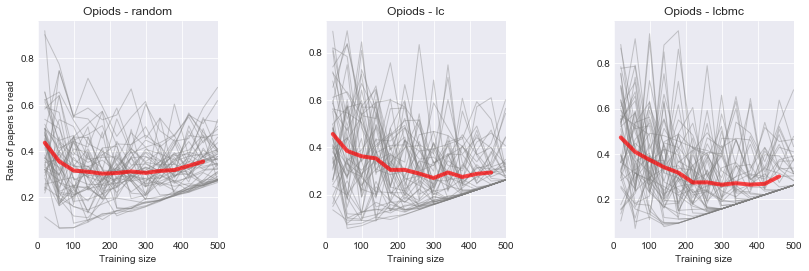

<Figure size 480x480 with 0 Axes>

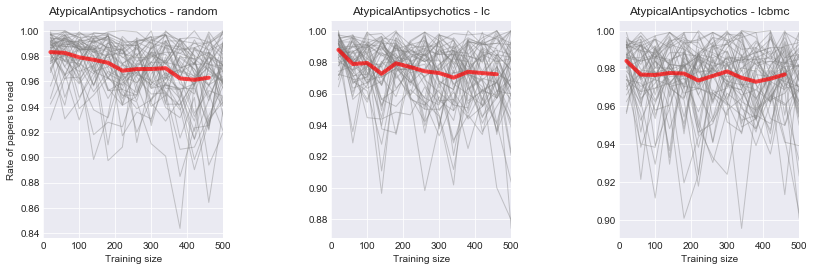

In [200]:
query_strategy =['random','lc','lcbmc']
color_list=['g','b','y']  
allowed_FN = 1

dataset_name = "ptsd"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "ACEInhibitors"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "ProtonPumpInhibitors"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "BetaBlockers"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "CalciumChannelBlockers"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "Opiods"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)

dataset_name = "AtypicalAntipsychotics"
df_results = collect_results(dataset_name, query_strategy)
show_qs_plot(dataset_name, query_strategy, df_results)


## Comparison

Here we would like to compare the results of active learning and passive learning approach. 

In [210]:
def read_passive_data(dataset_name, allowed_FN, init_included_papers):
    df_ = pd.read_csv(os.path.join('..', 'output','passive',dataset_name, 'systematic_review_results_allowed_FN_{}.csv'.format(allowed_FN))) 

    #calculate the number of papers to read
    df_['to_read_plus_train_number'] = df_['fp']+df_['tp']+df_['training_size']
    df_['to_read_plus_train_rate'] = df_['to_read_plus_train_number']/(df_['fp']+
                                            df_['fn']+df_['tp']+df_['tn']+ df_['training_size'])
    
    
    df_pas =df_.loc[(df_['init_included_papers']==init_included_papers),
               ['training_size','to_read_plus_train_rate']].groupby(['training_size'])['to_read_plus_train_rate'].mean()
     
    return pd.DataFrame(df_pas)

def read_active_data(query_strategy, df_results):
    
    df_mean=pd.DataFrame()
    df_mean['idx']=np.arange(20,500,40)
    col_names = ['simulation','train_size','to_read_plus_train_rate']
    mean_col_names=[]
    for q in query_strategy:
        df= df_results.loc[((df_results['q']==q)), col_names]

        #reshape the dataframe, using 'pivot' for visualization 
        df_res = df.pivot(index='train_size',columns='simulation',values='to_read_plus_train_rate')
        df_res['mean']=df_res.mean(axis=1)

        #keep mean of different qs 
        df_mean =pd.merge(df_mean,df_res['mean'].to_frame(), how='left', left_on='idx',right_index=True) 
        mean_col_names.append(q)

    
    df_mean.columns=['idx']+ mean_col_names
    return (df_mean, mean_col_names)

def merge_active_passive(df_pas, df_act, mean_col_names):
    all_col_names = ['passive','idx']+mean_col_names
    q_col_names = ['passive']+mean_col_names
    df_all = df_pas.merge(df_act,left_index=True,right_on='idx')
    df_all.columns =all_col_names
    return (df_all, q_col_names)
    
    
def show_qs_comparison_plot(dataset_name, query_strategy, df_results, color_list):
    col_names = ['simulation','train_size','to_read_plus_train_rate']

    df_act, mean_col_names = read_active_data(query_strategy, df_results)  
    df_pas = read_passive_data(dataset_name, allowed_FN, init_included_papers)
    df_all, q_col_names = merge_active_passive(df_pas, df_act, mean_col_names)

    plt.style.use('seaborn-darkgrid')
    my_dpi=96
    plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

    fig, ax = plt.subplots()
    
    # plot query strategies
    for i in range(0,len(q_col_names)):
        col_n = q_col_names[i]
        ax.plot(df_all['idx'], df_all[col_n], marker='', color= color_list[i], linewidth=4, alpha=0.7)
    

    ax.set_xlim([0,500])
    ax.set_xlabel('Training size')
    ax.set_ylabel('Ratio of papers to read')
    ax.set_title(dataset_name)

    # add query strategies to legend
    legend_list= list()
    for i in range(0,len(q_col_names)):
        col_line = mlines.Line2D([], [], color=color_list[i], markersize=15, label=q_col_names[i])
        legend_list.append(col_line)
    ax.legend(handles=legend_list)
    
    plt.show(block=False)

    if not os.path.isdir(os.path.join('..', 'output', 'active_learning','figures', dataset_name)):
        os.mkdir(os.path.join('..', 'output', 'active_learning','figures', dataset_name))
    fig.savefig(os.path.join('..','output','active_learning', "figures", dataset_name, "plot_compare_qs_{}_{}.png".format('Number_of_papers_to_read',dataset_name)), dpi=300)
    

<Figure size 480x480 with 0 Axes>

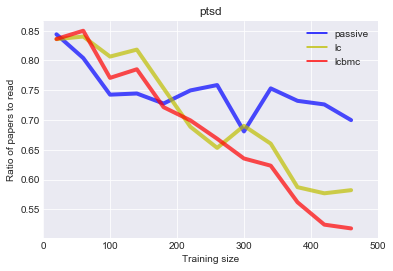

<Figure size 480x480 with 0 Axes>

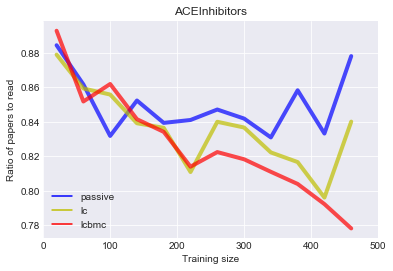

<Figure size 480x480 with 0 Axes>

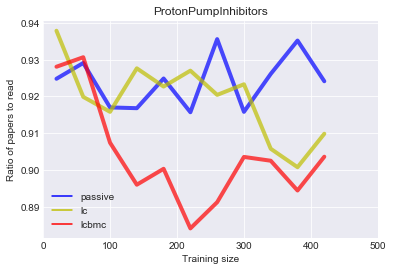

<Figure size 480x480 with 0 Axes>

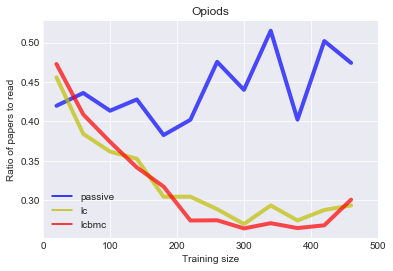

In [212]:
dataset_name = "ptsd"
query_strategy =['lc','lcbmc'] #'random',
color_list=['b','y','r'] #'g', 
allowed_FN = 1
init_included_papers =10
df_results = collect_results(dataset_name, query_strategy)
show_qs_comparison_plot(dataset_name, query_strategy, df_results, color_list)


dataset_name = "ACEInhibitors"
query_strategy =['lc','lcbmc'] #'random',
color_list=['b','y','r']  #'g',
allowed_FN = 1
init_included_papers =10
df_results = collect_results(dataset_name, query_strategy)
show_qs_comparison_plot(dataset_name, query_strategy, df_results, color_list)

dataset_name = "ProtonPumpInhibitors"
query_strategy =['lc','lcbmc'] #'random',
color_list=['b','y','r']  #'g', 
allowed_FN = 1
init_included_papers =10
df_results = collect_results(dataset_name, query_strategy)
show_qs_comparison_plot(dataset_name, query_strategy, df_results, color_list)

dataset_name = "Opiods"
allowed_FN = 1
init_included_papers =10
df_results = collect_results(dataset_name, query_strategy)
show_qs_comparison_plot(dataset_name, query_strategy, df_results, color_list)


Please note that the above results are for **initially included papers = 10 and allowed False-Negatives = 1 **